<a href="https://colab.research.google.com/github/IrutingaboRaissa/formative2_group18/blob/master/Advanced_CNN_Malaria_Diagnosis_CNN_Group18_EvenNumber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Malaria Diagnosis
This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018) and (Jason Brownlee, 2019). Acknowledge to NIH and Bangalor Hospital who make available this malaria dataset.

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis:
<font color='#ed7d31'>
* resource-constrained regions
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

*This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018), (Adrian Rosebrock, 2018) and (Jason Brownlee, 2019)*

## Configuration

In [1]:
#Mount the local drive project_forder
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/Colab Notebooks/10xDS/Projects/malaria-diagnosis/"

Mounted at /content/drive/
ls: cannot access '/content/drive/My Drive/Colab Notebooks/10xDS/Projects/malaria-diagnosis/': No such file or directory


In [2]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

2.19.0


'/device:GPU:0'

## Populating namespaces

In [3]:
# Importing basic libraries
import os
import random
import shutil
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D as Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [4]:
# Set image dimensions (adjust based on your dataset)
IMG_HEIGHT, IMG_WIDTH = 128, 128
BATCH_SIZE = 32
EPOCHS = 10

# Define the useful paths for data accessibility
ai_project = '.' #"/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
cell_images_dir = os.path.join(ai_project,'cell_images')
training_path = os.path.join(ai_project,'train')
testing_path = os.path.join(ai_project,'test')

print(f"Image dimensions: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training epochs: {EPOCHS}")
print(f"Data paths configured successfully!")

Image dimensions: 128x128
Batch size: 32
Training epochs: 10
Data paths configured successfully!


## Prepare DataSet

### *Download* DataSet

In [5]:
# Download the data in the allocated google cloud-server. If already down, turn downloadData=False
downloadData = True
if downloadData == True:
  indrive = False
  if indrive == True:
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip -P "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
    !unzip "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images.zip" -d "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/"
    !ls "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
  else: #incloud google server
    !rm -rf cell_images.*
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
    !unzip cell_images.zip >/dev/null 2>&1
    !ls

--2025-10-05 13:26:27--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 3.163.189.93, 3.163.189.83, 3.163.189.96, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|3.163.189.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M   198MB/s    in 1.7s    

2025-10-05 13:26:29 (198 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]

cell_images  cell_images.zip  drive  sample_data


## Baseline CNN Model
Define a basic ConvNet defined with ConvLayer: Conv2D => MaxPooling2D followed by Flatten => Dense => Dense(output)

![ConvNet](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/ConvNet.png?raw=1)


directory structure function

In [6]:
def create_directories():
    """Create train and test directories with class subdirectories"""
    if not os.path.exists(training_path):
        os.makedirs(os.path.join(training_path, 'Infected'))
        os.makedirs(os.path.join(training_path, 'Uninfected'))
        print("Training directories created!")

    if not os.path.exists(testing_path):
        os.makedirs(os.path.join(testing_path, 'Infected'))
        os.makedirs(os.path.join(testing_path, 'Uninfected'))
        print("Testing directories created!")

# Call the function
create_directories()

Training directories created!
Testing directories created!


data splitting function

In [7]:
def split_data():
    """Split data into train/test sets (80/20 split)"""
    # Source directories
    infected_dir = os.path.join(cell_images_dir, 'Parasitized')
    uninfected_dir = os.path.join(cell_images_dir, 'Uninfected')

    print(f"Looking for data in:")
    print(f"Infected: {infected_dir}")
    print(f"Uninfected: {uninfected_dir}")

    # Get all image files
    infected_images = [f for f in os.listdir(infected_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    uninfected_images = [f for f in os.listdir(uninfected_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    print(f"Found {len(infected_images)} infected images")
    print(f"Found {len(uninfected_images)} uninfected images")

    # Shuffle the lists
    random.shuffle(infected_images)
    random.shuffle(uninfected_images)

    # Calculate split indices
    infected_split = int(0.8 * len(infected_images))
    uninfected_split = int(0.8 * len(uninfected_images))

    # Split infected images
    for i, img in enumerate(infected_images):
        src = os.path.join(infected_dir, img)
        if i < infected_split:
            dst = os.path.join(training_path, 'Infected', img)
        else:
            dst = os.path.join(testing_path, 'Infected', img)

        if not os.path.exists(dst):
            shutil.copy2(src, dst)

    # Split uninfected images
    for i, img in enumerate(uninfected_images):
        src = os.path.join(uninfected_dir, img)
        if i < uninfected_split:
            dst = os.path.join(training_path, 'Uninfected', img)
        else:
            dst = os.path.join(testing_path, 'Uninfected', img)

        if not os.path.exists(dst):
            shutil.copy2(src, dst)

    print(f"\nData split completed:")
    print(f"Training - Infected: {infected_split}, Uninfected: {uninfected_split}")
    print(f"Testing - Infected: {len(infected_images) - infected_split}, Uninfected: {len(uninfected_images) - uninfected_split}")

# Run data splitting
split_data()

Looking for data in:
Infected: ./cell_images/Parasitized
Uninfected: ./cell_images/Uninfected
Found 13779 infected images
Found 13779 uninfected images

Data split completed:
Training - Infected: 11023, Uninfected: 11023
Testing - Infected: 2756, Uninfected: 2756


data generators

In [8]:
# Data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=['Infected', 'Uninfected']
)

test_generator = test_datagen.flow_from_directory(
    testing_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=['Infected', 'Uninfected']
)

print("Data generators created successfully!")
print(f"Training samples: {train_generator.samples}")
print(f"Testing samples: {test_generator.samples}")

Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.
Data generators created successfully!
Training samples: 22046
Testing samples: 5512


model architecture function

In [9]:
def create_simple_cnn():
    """
    Build the Simple CNN Model following the suggested architecture:
    - Input Layer + 3 Conv layers
    - Convolutional Layer 1 (32 filters, 3x3 kernel, ReLU)
    - Max-Pooling Layer 1 (2x2)
    - Convolutional Layer 2 (64 filters, 3x3 kernel, ReLU)
    - Max-Pooling Layer 2 (2x2)
    - Convolutional Layer 3 (128 filters, 3x3 kernel, ReLU)
    - Max-Pooling Layer 3 (2x2)
    - Flatten Layer
    - Dense Layer (128 units, ReLU)
    - Output Layer (2 units, Softmax)
    """
    model = Sequential([
        # Input Layer + Convolutional Layer 1
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        MaxPooling2D(2, 2),

        # Convolutional Layer 2
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Convolutional Layer 3
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Flatten Layer
        Flatten(),

        # Dense Layer
        Dense(128, activation='relu'),

        # Output Layer (2 units for binary classification with softmax)
        Dense(2, activation='softmax')
    ])

    return model

print("Model architecture function defined!")

Model architecture function defined!


create and compile model

In [10]:
model = create_simple_cnn()

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model created and compiled successfully!")
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model created and compiled successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

#Mariam Awini Issah (Advanced CNN And DenseNet121)
**Link [DenseNet121 colob](https://colab.research.google.com/drive/1iLbJJthgn-Osb3qvRFKzQPxvvXcQgwHg#scrollTo=Y5AWQyYa0LAQ)**

**2. Advanced CNN that incorporates techniques such as deeper layers or data augmentation,**


1. **Build Advanced CNN (residual blocks; softmax=2; baseline-compatible)**

In [11]:
# Builds a deeper CNN with residual blocks, BatchNorm, Dropout, L2;
# keeps 2-class SOFTMAX + categorical_crossentropy to match your baseline pipeline.

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(42)

def _res_block(x, filters, wd=1e-4, p_drop=0.4):
    y = layers.Conv2D(filters, 3, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(wd))(x)
    y = layers.BatchNormalization()(y); y = layers.ReLU()(y)
    y = layers.Conv2D(filters, 3, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(wd))(y)
    y = layers.BatchNormalization()(y)
    if p_drop > 0:
        y = layers.Dropout(p_drop)(y)
    # projection if channels differ
    if x.shape[-1] != filters:
        x = layers.Conv2D(filters, 1, padding="same", use_bias=False,
                          kernel_regularizer=regularizers.l2(wd))(x)
        x = layers.BatchNormalization()(x)
    out = layers.Add()([x, y]); out = layers.ReLU()(out)
    return out

def create_advanced_cnn(input_shape=(128,128,3),
                        wd=1e-4, p_drop=0.4, depth_stages=4,
                        dense_units=256, label_smoothing=0.05, lr=1e-3):
    """
    Baseline-compatible Advanced CNN:
      - Input: (IMG_HEIGHT, IMG_WIDTH, 3)
      - Output: Dense(2, softmax)
      - Loss: categorical_crossentropy (with label smoothing)
    """
    inputs = keras.Input(shape=input_shape)

    # Stem
    x = layers.Conv2D(32, 3, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(wd))(inputs)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)

    # Stage 1
    x = _res_block(x, 32, wd, p_drop)
    x = _res_block(x, 32, wd, p_drop)
    x = layers.MaxPool2D()(x)

    # Stage 2
    x = _res_block(x, 64, wd, p_drop)
    x = _res_block(x, 64, wd, p_drop)
    x = layers.MaxPool2D()(x)

    # Stage 3
    x = _res_block(x, 128, wd, p_drop)
    x = _res_block(x, 128, wd, p_drop)
    x = layers.MaxPool2D()(x)

    # Stage 4 (toggle for ablations)
    if depth_stages >= 4:
        x = _res_block(x, 256, wd, p_drop)
        x = _res_block(x, 256, wd, p_drop)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(dense_units, activation="relu",
                     kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.Dropout(p_drop)(x)
    outputs = layers.Dense(2, activation="softmax")(x)  # SAME as baseline

    model = keras.Model(inputs, outputs, name="AdvancedCNN")
    loss = keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss=loss,
                  metrics=["accuracy"])
    return model


2. **Instantiate the Advanced CNN (uses your baseline globals)**

In [12]:
# Instantiates the Advanced CNN using IMG_HEIGHT/IMG_WIDTH from your baseline and shows the summary.
# If you ran out of order, provide safe defaults; otherwise your baseline values are used.

try:
    IMG_HEIGHT, IMG_WIDTH
except NameError:
    IMG_HEIGHT, IMG_WIDTH = 128, 128  # fallback to your baseline defaults

model = create_advanced_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                            wd=1e-4, p_drop=0.4, depth_stages=4,
                            dense_units=256, label_smoothing=0.05, lr=1e-3)
model.summary()


Model: "AdvancedCNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,216 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      9,216 │ re_lu_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ re_lu[0][0],      │
│                     │ 32)               │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128,  │          0 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,216 │ re_lu_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │      9,216 │ re_lu_3[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_4[0][0]  

 Total params: 2,866,146 (10.93 MB)

 Trainable params: 2,861,346 (10.92 MB)

 Non-trainable params: 4,800 (18.75 KB)

3. **Callbacks (EarlyStopping, ReduceLROnPlateau, Checkpoint)**

In [13]:
# Good training practice per rubric: stops early, reduces LR on plateau, saves best weights.
from tensorflow import keras

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
lr_plateau = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)
ckpt = keras.callbacks.ModelCheckpoint("advanced_cnn_best.keras", monitor="val_accuracy",
                                       mode="max", save_best_only=True, verbose=1)


3. **Training loop + callbacks + cosine schedule (or ReduceLROnPlateau)**

In [16]:
def cosine_warmup(initial_lr, warmup_epochs, total_epochs):
    def schedule(epoch):
        if epoch < warmup_epochs:
            return initial_lr * (epoch + 1) / warmup_epochs
        progress = (epoch - warmup_epochs) / max(1, total_epochs - warmup_epochs)
        return 0.5 * initial_lr * (1 + tf.math.cos(tf.constant(3.14159) * progress))
    return keras.callbacks.LearningRateScheduler(schedule)

EPOCHS = 5
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True),
    cosine_warmup(1e-3, warmup_epochs=5, total_epochs=EPOCHS),
    keras.callbacks.ModelCheckpoint("advcnn_best.h5", monitor="val_auc", mode="max",
                                    save_best_only=True, verbose=0)
]



4. **Train the Advanced CNN (reuses your generators & plotter)**

In [17]:
# Trains with your existing train_generator/test_generator and reuses plot_training_history(history).
# Make sure you already created the generators in your baseline section.

if "train_generator" not in globals() or "test_generator" not in globals():
    raise RuntimeError("train_generator/test_generator not found. Run your baseline data generator cell first.")

print("Training Advanced CNN...")
history_adv = model.fit(
    train_generator,
    epochs=EPOCHS,                 # uses your baseline EPOCHS
    validation_data=test_generator,
    callbacks=[early_stop, lr_plateau, ckpt],
    verbose=1
)
print("Training complete.")

# Reuse your baseline plotting function if available
if "plot_training_history" in globals():
    plot_training_history(history_adv)


Training Advanced CNN...
Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9117 - loss: 0.5402
Epoch 1: val_accuracy improved from -inf to 0.88081, saving model to advanced_cnn_best.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 183s 246ms/step - accuracy: 0.9118 - loss: 0.5401 - val_accuracy: 0.8808 - val_loss: 0.5184 - learning_rate: 0.0010
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9511 - loss: 0.3296
Epoch 2: val_accuracy improved from 0.88081 to 0.92997, saving model to advanced_cnn_best.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 146s 211ms/step - accuracy: 0.9511 - loss: 0.3296 - val_accuracy: 0.9300 - val_loss: 0.3516 - learning_rate: 0.0010
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9501 - loss: 0.2924
Epoch 3: val_accuracy did not improve from 0.92997
689/689 ━━━━━━━━━━━━━━━━━━━━ 143s 208ms/step - accuracy: 0.9501 - loss: 0.2924 - val_accuracy: 0.8988 - val_loss: 0.3993 - learning_rate: 0.0010
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 

5. **Prepare predictions for evaluation**

In [18]:
# Collects ground-truth labels, predicted probabilities/classes, and sets the positive class = 'Infected'.
import numpy as np

idx_map = test_generator.class_indices           # {'Infected':0, 'Uninfected':1}
POS_NAME = "Infected"
pos_index = idx_map[POS_NAME]

y_true = test_generator.classes                  # shape (N,)
probs  = model.predict(test_generator, verbose=0)  # shape (N, 2)
y_pred = np.argmax(probs, axis=1)                # predicted class index
y_score = probs[:, pos_index]                    # probability of "Infected"


6. **Confusion Matrix (counts & normalized)**

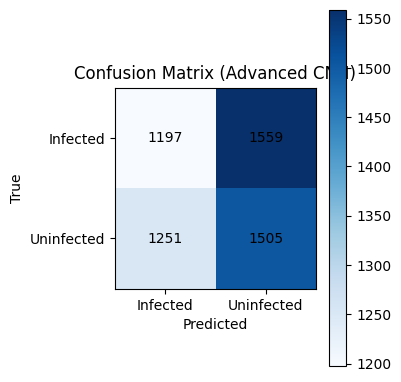

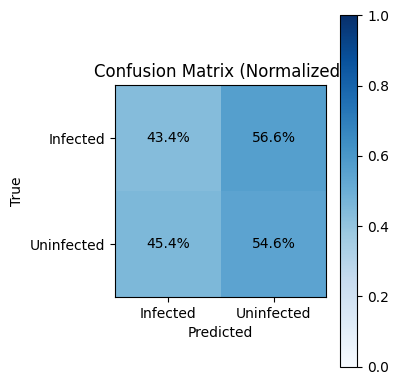

In [19]:
# Plots confusion matrix (counts) and normalized (% per true class) with labels.
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred, labels=[idx_map["Infected"], idx_map["Uninfected"]])

plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues"); plt.title("Confusion Matrix (Advanced CNN)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.colorbar()
plt.xticks([0,1], ["Infected","Uninfected"]); plt.yticks([0,1], ["Infected","Uninfected"])
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.tight_layout(); plt.show()

cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-12)
plt.figure(figsize=(4,4))
plt.imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)
plt.title("Confusion Matrix (Normalized)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.colorbar()
plt.xticks([0,1], ["Infected","Uninfected"]); plt.yticks([0,1], ["Infected","Uninfected"])
for (i,j), v in np.ndenumerate(cm_norm):
    plt.text(j, i, f"{v*100:.1f}%", ha="center", va="center")
plt.tight_layout(); plt.show()


7. **ROC curve & ROC–AUC**

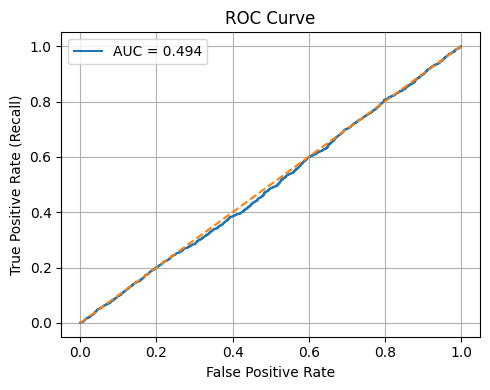

In [20]:
# Plots ROC curve for 'Infected' as positive class and prints AUC.
from sklearn.metrics import roc_curve, auc

y_true_pos = (y_true == pos_index).astype(int)
fpr, tpr, _ = roc_curve(y_true_pos, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()




8. **Precision–Recall curve & PR–AUC**

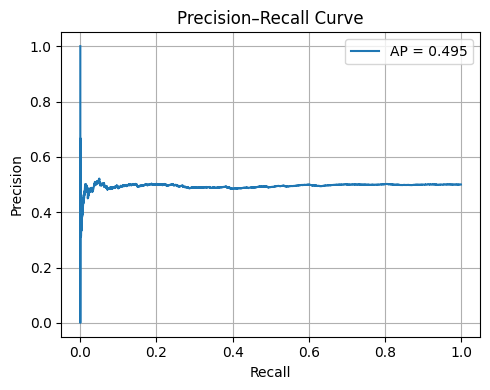

In [21]:
# Plots Precision–Recall curve and prints Average Precision (PR–AUC).
from sklearn.metrics import precision_recall_curve, average_precision_score

prec_curve, rec_curve, _ = precision_recall_curve(y_true_pos, y_score)
ap = average_precision_score(y_true_pos, y_score)

plt.figure(figsize=(5,4))
plt.plot(rec_curve, prec_curve, label=f"AP = {ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


**Metrics: Accuracy, Precision, Recall/Sensitivity, Specificity, Balanced Acc, F1**

In [22]:
# Computes and prints all rubric metrics plus clinical ones (specificity, balanced accuracy).
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="binary", pos_label=pos_index, zero_division=0
)

# Specificity for the negative (Uninfected) class:
neg_index = 1 - pos_index
tn = np.sum((y_true==neg_index) & (y_pred==neg_index))
fp = np.sum((y_true==neg_index) & (y_pred==pos_index))
specificity = tn / (tn + fp + 1e-12)
balanced_acc = 0.5 * (rec + specificity)

print("=== Advanced CNN Test Metrics ===")
print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall/Sensitivity: {rec:.4f}  "
      f"Specificity: {specificity:.4f}  Balanced Acc: {balanced_acc:.4f}  "
      f"F1: {f1:.4f}  ROC-AUC: {roc_auc:.4f}  PR-AUC(AP): {ap:.4f}")

print("\nClassification report (generator order):")
ordered_names = [k for k,_ in sorted(idx_map.items(), key=lambda kv: kv[1])]
print(classification_report(y_true, y_pred, target_names=ordered_names, zero_division=0))


=== Advanced CNN Test Metrics ===
Accuracy: 0.4902  Precision: 0.4890  Recall/Sensitivity: 0.4343  Specificity: 0.5461  Balanced Acc: 0.4902  F1: 0.4600  ROC-AUC: 0.4938  PR-AUC(AP): 0.4952

Classification report (generator order):
              precision    recall  f1-score   support

    Infected       0.49      0.43      0.46      2756
  Uninfected       0.49      0.55      0.52      2756

    accuracy                           0.49      5512
   macro avg       0.49      0.49      0.49      5512
weighted avg       0.49      0.49      0.49      5512



10. **Save the Advanced CNN model**

In [23]:
# Saves to a different file so your baseline model file stays intact.
model.save("advanced_malaria_cnn_model.keras")
print("Saved: advanced_malaria_cnn_model.keras")


Saved: advanced_malaria_cnn_model.keras


11. **Quick ablation runner for ≥7 experiments**

In [24]:
# Runs two hyperparameter experiments and displays results in table form
from sklearn.metrics import roc_curve
import pandas as pd

def run_experiment(tag, depth, p_drop, wd, dense, smooth, lr):
    tf.keras.backend.clear_session()
    m = create_advanced_cnn((IMG_HEIGHT, IMG_WIDTH, 3), wd=wd, p_drop=p_drop,
                            depth_stages=depth, dense_units=dense,
                            label_smoothing=smooth, lr=lr)
    hist = m.fit(train_generator, epochs=EPOCHS, validation_data=test_generator,
                 callbacks=[early_stop, lr_plateau], verbose=0)
    probs = m.predict(test_generator, verbose=0)
    y_t = test_generator.classes
    y_p = np.argmax(probs, axis=1)
    pos_idx = test_generator.class_indices.get("Infected", 0)
    y_s = probs[:, pos_idx]
    acc_ = accuracy_score(y_t, y_p)
    prc_, rec_, f1_, _ = precision_recall_fscore_support(y_t, y_p, average="binary",
                                                         pos_label=pos_idx, zero_division=0)
    fpr_, tpr_, _ = roc_curve((y_t==pos_idx).astype(int), y_s)
    auc_ = auc(fpr_, tpr_)
    return {"Exp":tag,"Depth":depth,"Dropout":p_drop,"WD":wd,"Dense":dense,"Smooth":smooth,"LR":lr,
            "Acc":acc_,"Prec":prc_,"Rec":rec_,"F1":f1_,"AUC":auc_}

# Only Two Experiments Instead of Seven
EXPERIMENTS = [
    ("E1", 3, 0.3, 1e-4, 128, 0.00, 1e-3),
    ("E2", 4, 0.4, 1e-4, 256, 0.05, 1e-3),
]

# Run & collect results
results = [run_experiment(*cfg) for cfg in EXPERIMENTS]

# Convert to DataFrame for Table Output
df_results = pd.DataFrame(results)
print("\n=== Experiment Results Table ===")
print(df_results)



=== Experiment Results Table ===
  Exp  Depth  Dropout      WD  Dense  Smooth     LR       Acc      Prec  \
0  E1      3      0.3  0.0001    128    0.00  0.001  0.503810  0.503919   
1  E2      4      0.4  0.0001    256    0.05  0.001  0.491473  0.490965   

        Rec        F1       AUC  
0  0.489840  0.496780  0.512495  
1  0.463353  0.476759  0.491123  
